In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

Dict for converting labels to their respective Letters

In [2]:
letter_dict = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    10: 'K',
    11: 'L',
    12: 'M',
    13: 'N',
    14: 'O',
    15: 'P',
    16: 'Q',
    17: 'R',
    18: 'S',
    19: 'T',
    20: 'U',
    21: 'V',
    22: 'W',
    23: 'X',
    24: 'Y'
}

In [3]:
signs_train = pd.read_csv('sign_mnist_train.csv')
signs_test = pd.read_csv('sign_mnist_test.csv')
signs_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


There are over 27,000 28x28 pictures in the training set

In [4]:
signs_train.shape

(27455, 785)

There are 24 possible labels, 9=J and 25=Z require motion so they are absent.

In [5]:
labels = signs_train['label'].values
labels_test = signs_test['label'].values
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

Labels have a somewhat uniform distribution in training set

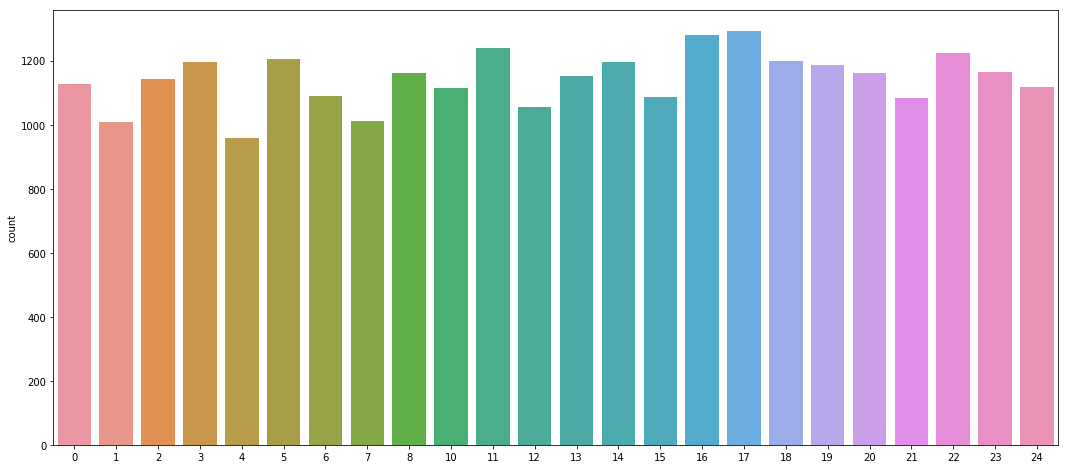

In [6]:
plt.figure(figsize = (18, 8))
sns.countplot(x = labels)

The testing data varies a bit more, E(4) and R(17) especially

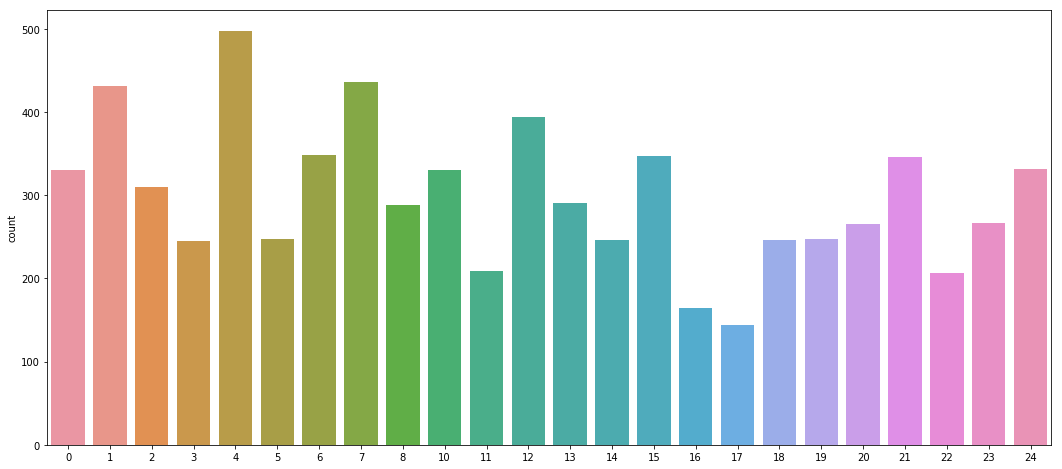

In [7]:
plt.figure(figsize = (18, 8))
sns.countplot(x = labels_test)

Create Dataset of Training Data

In [8]:
class AmericanSignsDataset(Dataset):
    """ASL Training Dataset"""
    
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.signs_frame = pd.read_csv(csv_file)
        self.labels_frame = self.signs_frame['label']
        self.signs_frame.drop('label', axis=1, inplace=True)
        self.transform = transform
                
    def __len__(self):
        return len(self.signs_frame)
    
    def __getitem__(self, idx):
        image = self.signs_frame.values[idx]
        image = np.array(image.reshape(28, 28))
        label = self.labels_frame.values[idx]

        if self.transform:
            image = self.transform(image)
            
        return (image, label)
        

We need to split a validation set off of the training data

In [9]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = AmericanSignsDataset(csv_file='sign_mnist_train.csv', transform=transform)
lengths = [int(len(train_data)*0.8), int(len(train_data)*0.2)]
train_subset, val_subset = torch.utils.data.random_split(train_data, lengths)

In [10]:
train_subset

Each Dataset entry contains the sign and its label

(28, 28)


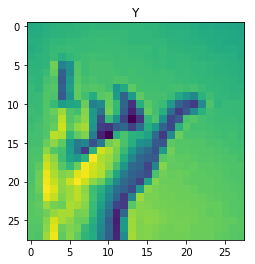

In [11]:
def imshow(img, title):
    npimg = img.numpy()
    npimg = npimg.squeeze()
    print(npimg.shape)
    plt.imshow(npimg)
    plt.title(title)
    plt.show()
imshow(train_subset[100][0], letter_dict[train_subset[100][1]])

The DataLoader will take batches of **10** signs

tensor([20,  3,  2,  2,  4,  5,  2,  7, 24, 21])


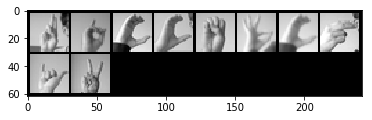

In [12]:
trainloader = DataLoader(train_subset, batch_size=10, shuffle=True, num_workers=0)
valloader = DataLoader(val_subset, batch_size=10, shuffle=True, num_workers=0)
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
show(torchvision.utils.make_grid(images))
print(labels)

Make sure the network will be run on the GPU if available

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Now we define the CNN, <br/><br/>
This model has 7 hidden layers:
- 3 Convolution layers using a 3x3 Kernel and Relu activation
- First two Conv layer are followed by a max-pooling layer
- After all Conv and Max-Pooling the results are squeezed into a 128 dense layer followed 64 size dense layer 
- Finally the 64 dense is put into a 26 dense layer and we look at the outputs 

In [47]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(3 * 3 * 64, 128)
        self.fc2 = nn.Linear(128, 26)
        self.dropout = nn.Dropout()
        
    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        # The max pool here is odd
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = x.view(-1, 3 * 3 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
net = Net()
net = net.to(device)

In [48]:
net

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
  (dropout): Dropout(p=0.5)
)

Using **Cross Entropy** for loss and **Stochastic Gradient Descent** with momentum<br />
Cross Entropy is a common loss used for classification problems, SGD makes the progress of gradient descent but avoid having to look at the entire dataset on each step. The momentum also helps break through any local minima that we may run into.

In [49]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

Time to train! I'm running the training data through the model for 20 epochs.

In [50]:
loss_log = []
for epoch in range(20): # loop over dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Debug
       # print(type(inputs))
       # print(labels.size())
        #print(inputs.size())
        #print(inputs.dim())
        
        # zero parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs.float())
        
        #print(outputs.shape)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 500 == 499: # print every 500 iterations
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 500))
            loss_log.append(running_loss / 500)
            running_loss = 0.0
            
print('Finished Training')

[1,   500] loss: 3.013
[1,  1000] loss: 2.021
[1,  1500] loss: 1.329
[1,  2000] loss: 0.929
[2,   500] loss: 0.622
[2,  1000] loss: 0.509
[2,  1500] loss: 0.362
[2,  2000] loss: 0.294
[3,   500] loss: 0.213
[3,  1000] loss: 0.180
[3,  1500] loss: 0.151
[3,  2000] loss: 0.149
[4,   500] loss: 0.102
[4,  1000] loss: 0.098
[4,  1500] loss: 0.097
[4,  2000] loss: 0.083
[5,   500] loss: 0.077
[5,  1000] loss: 0.059
[5,  1500] loss: 0.058
[5,  2000] loss: 0.055
[6,   500] loss: 0.061
[6,  1000] loss: 0.056
[6,  1500] loss: 0.046
[6,  2000] loss: 0.041
[7,   500] loss: 0.040
[7,  1000] loss: 0.041
[7,  1500] loss: 0.040
[7,  2000] loss: 0.038
[8,   500] loss: 0.022
[8,  1000] loss: 0.030
[8,  1500] loss: 0.036
[8,  2000] loss: 0.026
[9,   500] loss: 0.017
[9,  1000] loss: 0.036
[9,  1500] loss: 0.020
[9,  2000] loss: 0.014
[10,   500] loss: 0.026
[10,  1000] loss: 0.026
[10,  1500] loss: 0.021
[10,  2000] loss: 0.022
[11,   500] loss: 0.026
[11,  1000] loss: 0.019
[11,  1500] loss: 0.026
[11,

Text(0, 0.5, 'loss')

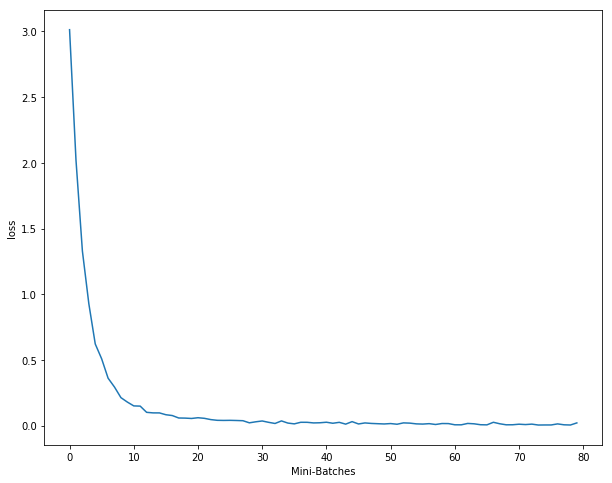

In [51]:
%matplotlib inline

plt.figure(figsize=(10,8))
plt.plot(loss_log)
plt.xlabel('Mini-Batches')
plt.ylabel('loss')
#plt.plot(np.ones(len(acc_log)), linestyle='dashed')

The more we train on the same data, the higher chance of **overfitting** so we must use our validation set to keep our model in check.

GroundTruth:      X     T     V     U     Y     S     A     F     X     X


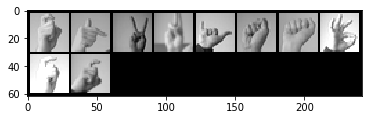

In [52]:
dataiter = iter(valloader)
images, labels = dataiter.next()

# Print images
show(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % letter_dict[labels[j].item()] for j in range(10)))

In [53]:
outputs = net(images.float().to(device))

In [54]:
_, predicted = torch.max(outputs, 1)

print('Predictied: ', ' '.join('%5s' % letter_dict[predicted[j].item()] for j in range(10)))

Predictied:      X     T     V     U     Y     S     A     F     X     X


Results with Validation set:

In [55]:
def run_test(loader):
    correct = 0
    total = 0
    y_pred = np.array([])
    y_actual = np.array([])
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images.float().to(device))
            _, predicted = torch.max(outputs.data, 1)

            y_pred = np.append(y_pred, predicted.cpu().numpy())
            y_actual = np.append(y_actual, labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    return correct/total, y_pred, y_actual

In [56]:
acc, y_pred, y_actual = run_test(valloader)
print('Accuracy of the network on the validation images: %d %%' % (
    100 * acc))

Accuracy of the network on the validation images: 99 %


**Confusion matrix** of results:

In [57]:
from sklearn.metrics import confusion_matrix
print(y_pred)
print(y_actual)
confusion_matrix(y_actual, y_pred)

[ 1. 22. 12. ... 13.  2.  1.]
[ 1. 22. 12. ... 13.  2.  1.]


array([[237,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 195,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 233,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 233,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 189,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 232,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   1,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0, 237,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       237
         1.0       1.00      1.00      1.00       195
         2.0       1.00      1.00      1.00       233
         3.0       1.00      1.00      1.00       233
         4.0       1.00      0.99      0.99       191
         5.0       1.00      0.99      1.00       234
         6.0       1.00      1.00      1.00       237
         7.0       1.00      1.00      1.00       195
         8.0       1.00      1.00      1.00       241
        10.0       1.00      1.00      1.00       240
        11.0       1.00      1.00      1.00       253
        12.0       1.00      1.00      1.00       196
        13.0       1.00      1.00      1.00       212
        14.0       1.00      1.00      1.00       228
        15.0       1.00      1.00      1.00       214
        16.0       1.00      1.00      1.00       238
        17.0       1.00      1.00      1.00       264
        18.0       1.00    

The following are tunable hyperparams:
- batch size
- epochs
- learning rate
- momentum
- dropout prob

This is great training and validation results! Time to move on to testing

In [59]:
test_data = AmericanSignsDataset(csv_file='sign_mnist_test.csv', transform=transform)

In [60]:
testloader = DataLoader(test_data, batch_size=10, shuffle=True, num_workers=0)

In [61]:
acc, y_pred, y_actual = run_test(testloader)
print('Accuracy of the network on the validation images: %d %%' % (
    100 * acc))

Accuracy of the network on the validation images: 91 %


In [62]:
confusion_matrix(y_actual, y_pred)

array([[330,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 412,   0,   0,   0,   4,   0,   0,   0,   2,   0,   0,   0,
          0,   1,   2,   0,   0,   0,   0,   0,  11,   0,   0],
       [  0,   0, 300,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,
          7,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   1,   0, 237,   0,   1,   0,   0,   0,   1,   1,   0,   1,
          0,   0,   0,   0,   1,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 482,   0,   0,   0,   0,   0,   0,   6,   0,
          1,   0,   0,   0,   9,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 246,   0,   0,   0,   0,   0,   0,   0,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 294,  10,   0,   0,   0,   0,   0,
          1,   6,  27,   1,   0,   3,   0,   0,   0,   6,   0],
       [  0,   0,   0,   0,   0,   0,  21

In [63]:
print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94       331
         1.0       1.00      0.95      0.97       432
         2.0       0.93      0.97      0.95       310
         3.0       0.97      0.97      0.97       245
         4.0       0.97      0.97      0.97       498
         5.0       0.97      1.00      0.98       247
         6.0       0.93      0.84      0.89       348
         7.0       0.94      0.94      0.94       436
         8.0       0.84      0.89      0.86       288
        10.0       0.93      0.94      0.93       331
        11.0       0.88      0.99      0.93       209
        12.0       0.89      0.85      0.87       394
        13.0       0.86      0.76      0.81       291
        14.0       0.96      0.89      0.92       246
        15.0       0.94      0.98      0.96       347
        16.0       0.81      1.00      0.89       164
        17.0       0.84      0.74      0.79       144
        18.0       0.88    